# Credit Card Fraud Detection

#### Importing the Libs

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
warnings.filterwarnings('ignore')

from plotnine import ggplot, aes, geom_density, ggtitle, xlab, ylab, theme_minimal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import uniform, randint
from joblib import dump

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.metrics import make_scorer, f1_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
np.set_printoptions(suppress=True)


In [38]:
df_path = r"D:\ML\Classification\Credit_card_fraud_detection\data\creditcard.csv"

df = pd.read_csv(df_path)

df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,0.091,-0.552,-0.618,-0.991,-0.311,1.468,-0.470,0.208,0.026,0.404,0.251,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,-0.167,1.613,1.065,0.489,-0.144,0.636,0.464,-0.115,-0.183,-0.146,-0.069,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,0.208,0.625,0.066,0.717,-0.166,2.346,-2.890,1.110,-0.121,-2.262,0.525,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0


In [39]:
print("\nShape of the dataset (rows, columns):")
print(df.shape)


Shape of the dataset (rows, columns):
(284807, 31)


In [40]:
print("\nColumns in the dataset:")
print(df.columns)


Columns in the dataset:
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [41]:
print("\nDropping the 'Time' column...")
df.drop("Time", inplace=True, axis="columns")
print("'Time' column dropped successfully!")


print("\nData types of the columns:")
print(df.dtypes)


Dropping the 'Time' column...
'Time' column dropped successfully!

Data types of the columns:
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


### Data Cleaning

In [42]:
print(df.isna().sum())

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [43]:
# Filter out fraud transactions where "Class" is 1
print("\nFiltering fraud transactions...")
df_fraud_transaction = df[df["Class"] == 1]
print(f"Number of fraud transactions: {df_fraud_transaction.shape[0]}")

# Filter out true transactions where "Class" is 0
print("\nFiltering true transactions...")
df_true_transaction = df[df["Class"] == 0]
print(f"Number of true transactions: {df_true_transaction.shape[0]}")

# Randomly sample 10% of the true transactions
print("\nSampling 10% of true transactions...")
df_true_transaction = df_true_transaction.sample(frac=0.1, random_state=42)
print(f"Number of sampled true transactions: {df_true_transaction.shape[0]}")

data = pd.concat([df_true_transaction, df_fraud_transaction]).reset_index(drop=True)

print("\nShape of the final dataset (rows, columns):")
print(data.shape)




Filtering fraud transactions...
Number of fraud transactions: 492

Filtering true transactions...
Number of true transactions: 284315

Sampling 50% of true transactions...
Number of sampled true transactions: 28432

Shape of the final dataset (rows, columns):
(28924, 30)


In [44]:
total_transactions = data.shape[0]

fraud_transactions = data[data["Class"] == 1].shape[0]

fraud_percentage = (fraud_transactions / total_transactions) * 100

print(f"Percentage of Fraudulent Transactions: {fraud_percentage:.2f}%")

Percentage of Fraudulent Transactions: 1.70%


In [45]:
data["Amount"].describe()

count   28924.000
mean       87.325
std       226.178
min         0.000
25%         5.390
50%        21.950
75%        77.000
max      8360.000
Name: Amount, dtype: float64

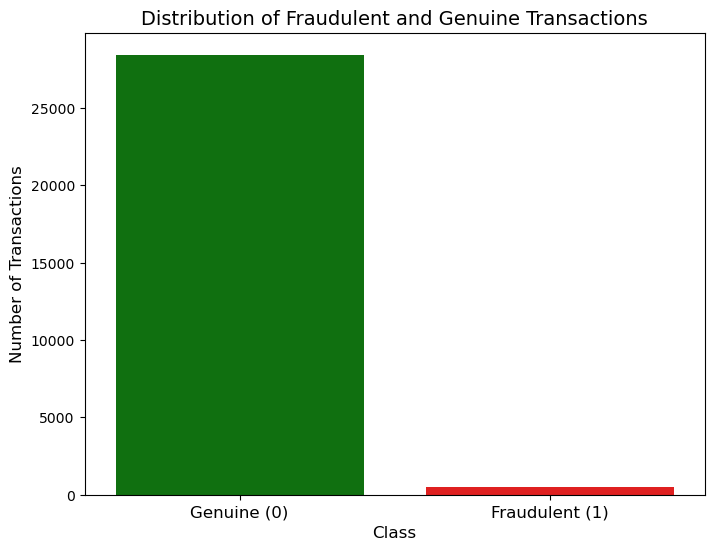

In [46]:
# Plotting with Seaborn
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Class', palette=['green', 'red'])

# Adding titles and labels
plt.title('Distribution of Fraudulent and Genuine Transactions', fontsize=14)
plt.xticks([0, 1], ['Genuine (0)', 'Fraudulent (1)'], fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xlabel('Class', fontsize=12)

plt.show()

### Feature Encoding

In [47]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

cols_to_scale = ["Amount"]

data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])

data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000,28924.000
mean,-0.067,0.063,-0.113,0.079,-0.036,-0.027,-0.092,0.015,-0.031,-0.087,0.060,-0.086,-0.002,-0.109,-0.002,-0.067,-0.099,-0.036,0.016,0.007,0.006,0.000,0.001,-0.005,-0.007,0.003,0.003,0.002,0.010,0.017
std,2.163,1.733,1.926,1.547,1.551,1.338,1.621,1.425,1.181,1.420,1.163,1.377,0.990,1.385,0.922,1.110,1.457,0.944,0.832,0.738,0.847,0.739,0.640,0.606,0.527,0.484,0.434,0.313,0.027,0.129
min,-33.404,-38.437,-31.104,-5.176,-27.737,-20.368,-43.557,-41.044,-13.434,-24.588,-3.423,-18.684,-3.642,-19.214,-4.499,-14.130,-25.163,-9.499,-4.367,-23.647,-22.798,-8.887,-30.270,-2.837,-6.429,-1.582,-9.544,-8.308,0.000,0.000
25%,-0.936,-0.595,-0.953,-0.821,-0.708,-0.779,-0.577,-0.206,-0.660,-0.559,-0.755,-0.426,-0.650,-0.455,-0.589,-0.495,-0.498,-0.516,-0.450,-0.213,-0.227,-0.550,-0.164,-0.357,-0.321,-0.327,-0.071,-0.053,0.001,0.000
50%,0.002,0.083,0.153,0.016,-0.059,-0.279,0.034,0.026,-0.058,-0.104,-0.011,0.136,-0.024,0.039,0.044,0.050,-0.068,-0.014,0.011,-0.062,-0.025,0.008,-0.010,0.039,0.014,-0.046,0.002,0.012,0.003,0.000
75%,1.306,0.838,1.003,0.791,0.622,0.396,0.574,0.339,0.590,0.442,0.778,0.612,0.654,0.485,0.662,0.515,0.402,0.494,0.471,0.138,0.192,0.527,0.152,0.434,0.342,0.248,0.095,0.081,0.009,0.000
max,2.420,22.058,3.893,12.700,29.162,16.411,21.445,20.007,10.371,12.340,12.019,4.122,3.734,6.090,3.881,5.562,8.538,4.244,5.572,13.658,27.203,8.362,17.752,4.016,5.852,3.517,9.880,15.870,1.000,1.000


In [48]:
data.Amount.describe()

count   28924.000
mean        0.010
std         0.027
min         0.000
25%         0.001
50%         0.003
75%         0.009
max         1.000
Name: Amount, dtype: float64

### Drop Duplicates

In [49]:
print("\nChecking for duplicate rows in the dataset...")
num_duplicates = data.duplicated().sum()
print(f"Number of duplicate rows found: {num_duplicates}")


Checking for duplicate rows in the dataset...
Number of duplicate rows found: 228


In [50]:
data.drop_duplicates(inplace=True)

print("\nShape of the dataset after removing duplicates (rows, columns):")
print(data.shape)


Shape of the dataset after removing duplicates (rows, columns):
(28696, 30)


### VIF to measure multicolinearity

In [51]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df["Columns"] = data.columns
    vif_df["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

calculate_vif(data)

,Columns,VIF
0,V1,1.584
1,V2,3.001
2,V3,1.821
3,V4,1.259
4,V5,2.179
5,V6,1.283
6,V7,2.934
7,V8,1.160
8,V9,1.123
9,V10,1.592


### Train-Test Split

In [52]:
X = data.drop("Class", axis="columns")
y = data["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (21522, 29)
Shape of X_test: (7174, 29)
Shape of y_train: (21522,)
Shape of y_test: (7174,)


## Model Training

#### Attempt 1

1. Logistic Regression, RandomForest & XGB
1. No handling of class imbalance

In [53]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(f"{report}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7052
           1       0.97      0.84      0.90       122

    accuracy                           1.00      7174
   macro avg       0.98      0.92      0.95      7174
weighted avg       1.00      1.00      1.00      7174



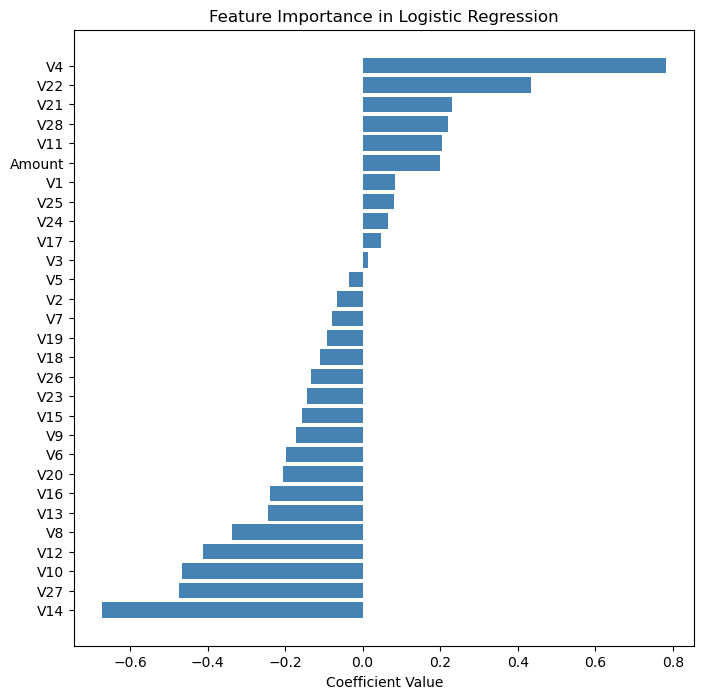

In [54]:
feature_importance = model.coef_[0]

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 8))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.show()

In [55]:
model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(f"{report}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7052
           1       0.99      0.88      0.93       122

    accuracy                           1.00      7174
   macro avg       0.99      0.94      0.96      7174
weighted avg       1.00      1.00      1.00      7174



In [56]:
param_dist = {
    'C': np.logspace(-4, 4, 20),  # Logarithmically spaced values from 10^-4 to 10^4
    'solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg']   # Algorithm to use in the optimization problem
}

# Create the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000)  # Increased max_iter for convergence

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='f1',
    cv=3,  # 5-fold cross-validation
    verbose=2,
    random_state=42,  # Set a random state for reproducibility
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'solver': 'newton-cg', 'C': 0.08858667904100823}
Best Score: 0.8748930487895349
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7052
           1       0.97      0.84      0.90       122

    accuracy                           1.00      7174
   macro avg       0.98      0.92      0.95      7174
weighted avg       1.00      1.00      1.00      7174



#### Attempt 2

1. Logistic Regression & XGB
1. Handle Class Imbalance Using Under Sampling

In [57]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

y_train_rus.value_counts()

Class
0    351
1    351
Name: count, dtype: int64

In [58]:
model = LogisticRegression()
model.fit(X_train_rus, y_train_rus)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(f"{report}")

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      7052
           1       0.34      0.92      0.49       122

    accuracy                           0.97      7174
   macro avg       0.67      0.94      0.74      7174
weighted avg       0.99      0.97      0.98      7174



In [59]:
model = XGBClassifier(**random_search.best_params_)
model.fit(X_train_rus, y_train_rus)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(f"{report}")

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      7052
           1       0.27      0.95      0.42       122

    accuracy                           0.96      7174
   macro avg       0.63      0.95      0.70      7174
weighted avg       0.99      0.96      0.97      7174



#### Attempt 3

1. Logistic Regression
1. Handle Class Imbalance Using SMOTE Tomek
1. Parameter tunning using optuna

In [60]:
smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

y_train_smt.value_counts()

Class
0    21171
1    21171
Name: count, dtype: int64

In [61]:
model = LogisticRegression()
model.fit(X_train_smt, y_train_smt)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(f"{report}")

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7052
           1       0.40      0.93      0.56       122

    accuracy                           0.97      7174
   macro avg       0.70      0.96      0.77      7174
weighted avg       0.99      0.97      0.98      7174



In [62]:
model = XGBClassifier(**random_search.best_params_)
model.fit(X_train_smt, y_train_smt)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(f"{report}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7052
           1       0.92      0.89      0.90       122

    accuracy                           1.00      7174
   macro avg       0.96      0.95      0.95      7174
weighted avg       1.00      1.00      1.00      7174



In [63]:
# RandomizedSearch CV for Attempt 1: Logistic Regression

param_dist = {
    'C': np.logspace(-4, 4, 20),  # Logarithmically spaced values from 10^-4 to 10^4
    'solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg']   # Algorithm to use in the optimization problem
}

# Create the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000)  # Increased max_iter for convergence

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='f1',
    cv=3,  # 5-fold cross-validation
    verbose=2,
    random_state=42,  # Set a random state for reproducibility
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train_smt, y_train_smt)

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'solver': 'liblinear', 'C': 1438.44988828766}
Best Score: 0.9407625871252154
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7052
           1       0.40      0.93      0.56       122

    accuracy                           0.97      7174
   macro avg       0.70      0.96      0.77      7174
weighted avg       0.99      0.97      0.98      7174



#### Model Evaluation : ROC/AUC

In [64]:
probabilities = best_model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities)
fpr[:5], tpr[:5], thresholds[:5]

(array([0.       , 0.       , 0.       , 0.       , 0.0001418]),
 array([0.        , 0.28688525, 0.31967213, 0.55737705, 0.55737705]),
 array([2., 1., 1., 1., 1.]))

In [65]:
area = auc(fpr, tpr)
area

0.9886987065638861

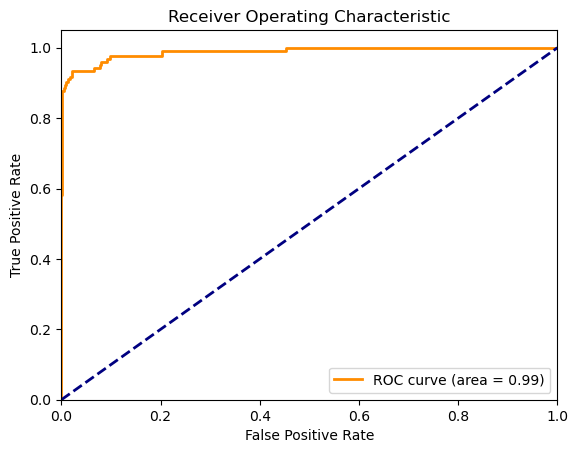

In [66]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [67]:
gini_coefficient = 2 * area - 1

print("AUC:", area)
print("Gini Coefficient:", gini_coefficient)

AUC: 0.9886987065638861
Gini Coefficient: 0.9773974131277723


- AUC of 0.98: The model is very good at distinguishing between 0 & 1.

- Gini coefficient of 0.97: This further confirms that the model is highly effective in its predictions

- The Gini coefficient ranges from -1 to 1, where a value closer to 1 signifies a perfect model, 0 indicates a model with no discriminative power, and -1 signifies a perfectly incorrect model.

#### Finalize The Model and Visualize Feature Importance

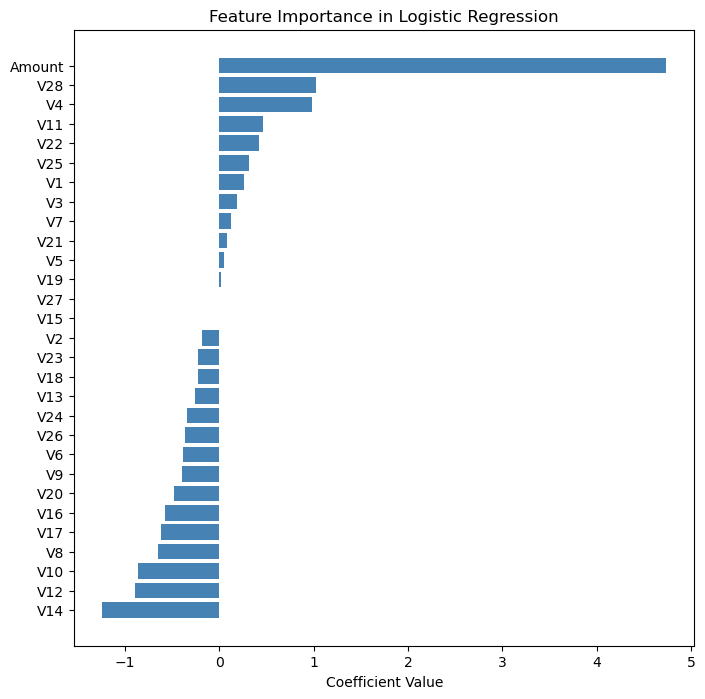

In [68]:
final_model = best_model

feature_importance = final_model.coef_[0]

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 8))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.show()